# 01 - EDA NonResidential (Seattle 2016)

Objectif: analyser uniquement les batiments `NonResidential` et preparer la modelisation de facon robuste et simple.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
from sklearn.cluster import KMeans


In [2]:
# Chargement + filtres metier
df = pd.read_csv('../2016_Building_Energy_Benchmarking.csv')
df = df[df['BuildingType'] == 'NonResidential'].copy()
df = df[df['ComplianceStatus'] == 'Compliant'].copy()
if 'Outlier' in df.columns:
    df = df[df['Outlier'].fillna('').str.lower() != 'high outlier']

print('Shape apres filtres:', df.shape)
df[['BuildingType', 'PrimaryPropertyType', 'Neighborhood']].head()
df['BuildingAge'] = (2016 - df['YearBuilt']).clip(lower=0)


Shape apres filtres: (1432, 46)


In [3]:
# Vue d'ensemble
print(df[['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']].describe().T)
print('\nTop 10 types de batiments:')
print(df['PrimaryPropertyType'].value_counts().head(10))

                      count          mean           std          min  \
TotalGHGEmissions    1432.0  1.687461e+02  5.910355e+02     -0.80000   
SiteEnergyUse(kBtu)  1432.0  7.814269e+06  1.921578e+07  57133.19922   

                              25%         50%          75%           max  
TotalGHGEmissions    1.976000e+01       48.24      134.600  1.230716e+04  
SiteEnergyUse(kBtu)  1.219834e+06  2650597.50  6968646.375  2.930908e+08  

Top 10 types de batiments:
PrimaryPropertyType
Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
Name: count, dtype: int64


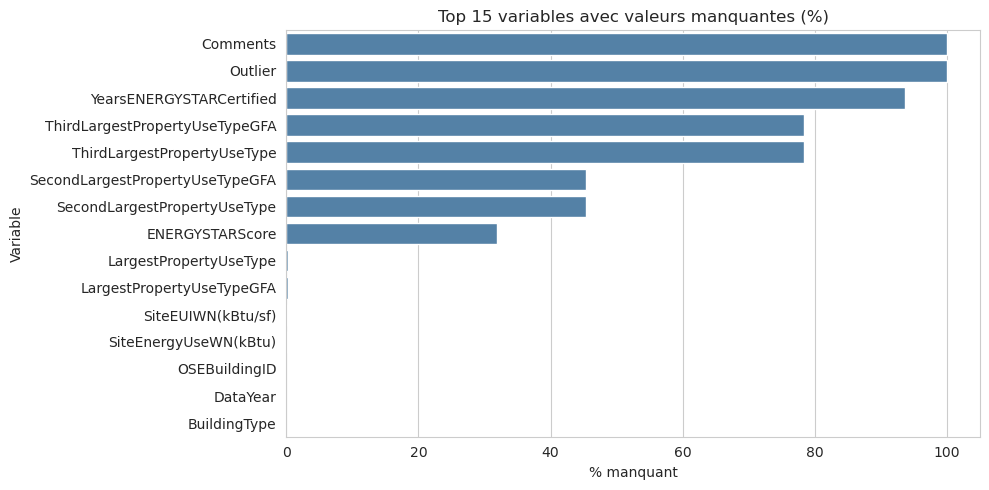

Comments                           100.000000
Outlier                            100.000000
YearsENERGYSTARCertified            93.715084
ThirdLargestPropertyUseTypeGFA      78.351955
ThirdLargestPropertyUseType         78.351955
SecondLargestPropertyUseTypeGFA     45.321229
SecondLargestPropertyUseType        45.321229
ENERGYSTARScore                     31.843575
LargestPropertyUseType               0.279330
LargestPropertyUseTypeGFA            0.279330
SiteEUIWN(kBtu/sf)                   0.069832
SiteEnergyUseWN(kBtu)                0.069832
OSEBuildingID                        0.000000
DataYear                             0.000000
BuildingType                         0.000000
dtype: float64

In [4]:
# Valeurs manquantes (top 15)
missing = (df.isna().mean() * 100).sort_values(ascending=False)
missing_top = missing.head(15)

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_top.values, y=missing_top.index, color='steelblue')
plt.title('Top 15 variables avec valeurs manquantes (%)')
plt.xlabel('% manquant')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

missing_top

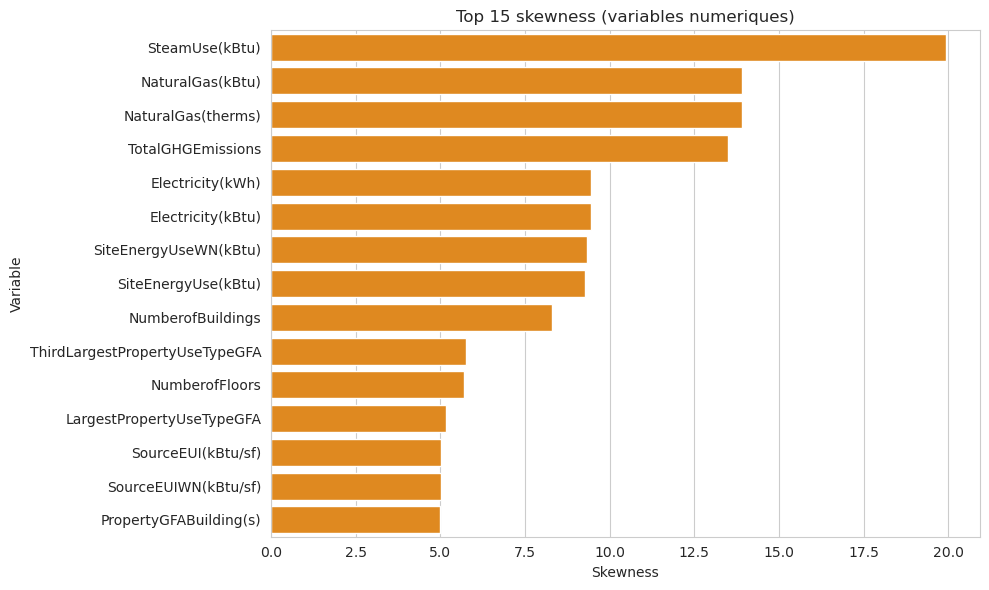

SteamUse(kBtu)                    19.933722
NaturalGas(kBtu)                  13.892014
NaturalGas(therms)                13.892014
TotalGHGEmissions                 13.504185
Electricity(kWh)                   9.459052
Electricity(kBtu)                  9.459052
SiteEnergyUseWN(kBtu)              9.325123
SiteEnergyUse(kBtu)                9.260072
NumberofBuildings                  8.308823
ThirdLargestPropertyUseTypeGFA     5.756943
NumberofFloors                     5.702869
LargestPropertyUseTypeGFA          5.163286
SourceEUI(kBtu/sf)                 5.033346
SourceEUIWN(kBtu/sf)               5.021742
PropertyGFABuilding(s)             4.980762
PropertyGFAParking                 4.937581
PropertyGFATotal                   4.709443
SiteEUI(kBtu/sf)                   3.830439
GHGEmissionsIntensity              3.767506
SiteEUIWN(kBtu/sf)                 3.742083
dtype: float64

In [5]:
# Skewness des variables numeriques
num_df = df.select_dtypes(include=[np.number]).copy()
num_df = num_df.drop(columns=['OSEBuildingID', 'DataYear'], errors='ignore')
sk = num_df.skew(numeric_only=True).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=sk.head(15).values, y=sk.head(15).index, color='darkorange')
plt.title('Top 15 skewness (variables numeriques)')
plt.xlabel('Skewness')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

sk.head(20)

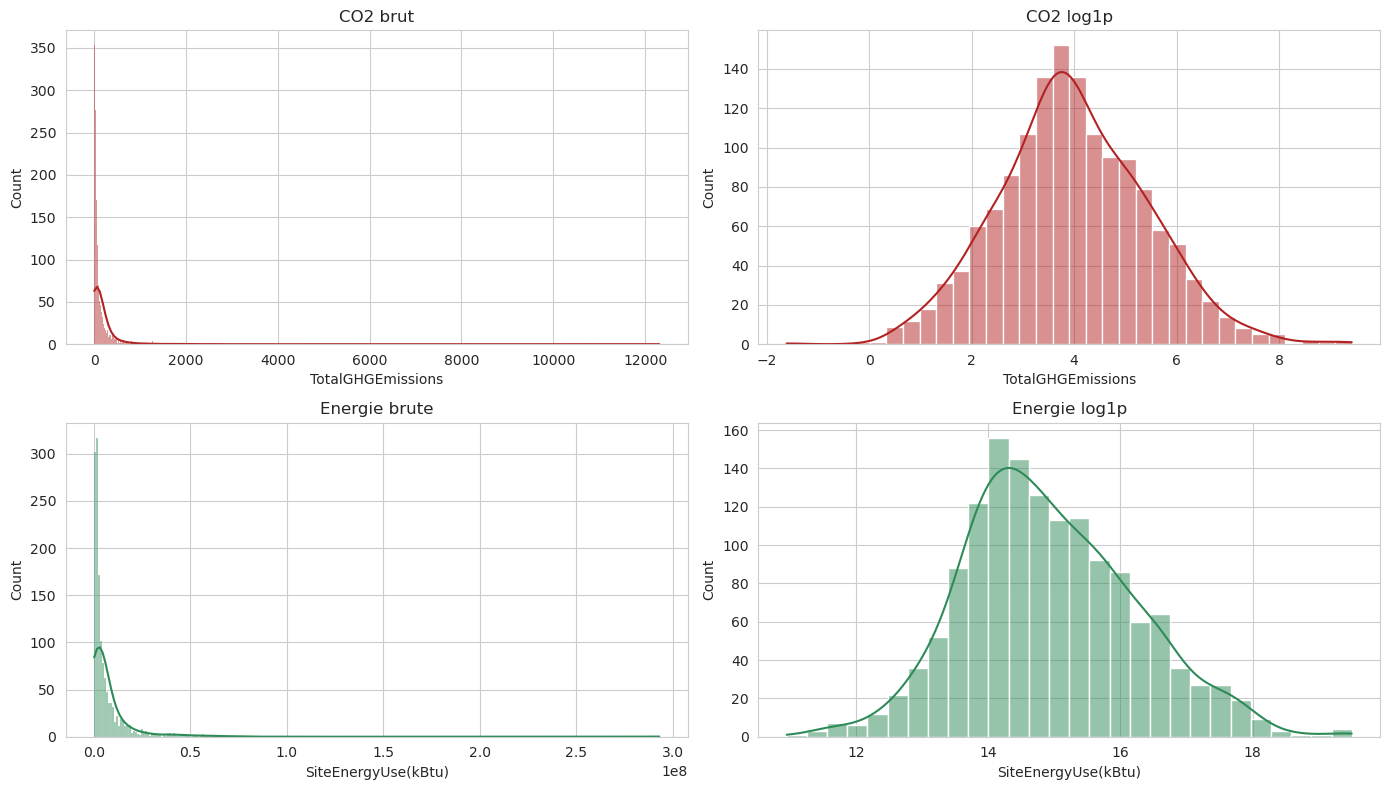

In [6]:
# Distribution des cibles avant/apres log1p
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sns.histplot(df['TotalGHGEmissions'].dropna(), kde=True, ax=axes[0,0], color='firebrick')
axes[0,0].set_title('CO2 brut')

sns.histplot(np.log1p(df['TotalGHGEmissions'].dropna()), kde=True, ax=axes[0,1], color='firebrick')
axes[0,1].set_title('CO2 log1p')

sns.histplot(df['SiteEnergyUse(kBtu)'].dropna(), kde=True, ax=axes[1,0], color='seagreen')
axes[1,0].set_title('Energie brute')

sns.histplot(np.log1p(df['SiteEnergyUse(kBtu)'].dropna()), kde=True, ax=axes[1,1], color='seagreen')
axes[1,1].set_title('Energie log1p')

plt.tight_layout()
plt.show()

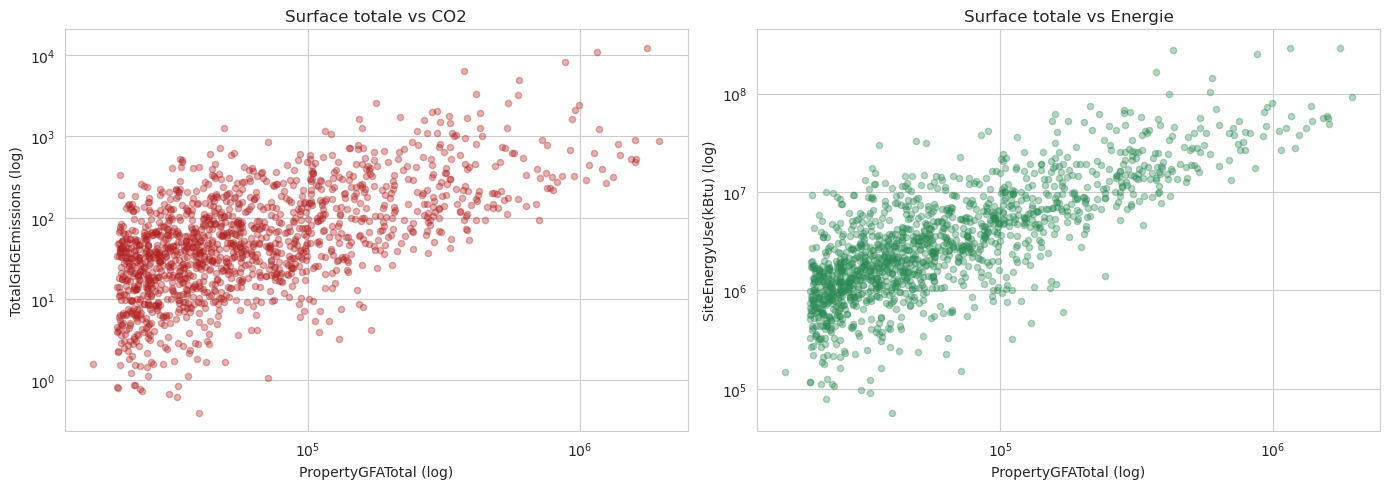

In [7]:
# Graphique explicatif: surface vs cibles (echelle log pour mieux lire)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['PropertyGFATotal'], df['TotalGHGEmissions'], alpha=0.35, s=20, color='firebrick')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Surface totale vs CO2')
axes[0].set_xlabel('PropertyGFATotal (log)')
axes[0].set_ylabel('TotalGHGEmissions (log)')

axes[1].scatter(df['PropertyGFATotal'], df['SiteEnergyUse(kBtu)'], alpha=0.35, s=20, color='seagreen')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Surface totale vs Energie')
axes[1].set_xlabel('PropertyGFATotal (log)')
axes[1].set_ylabel('SiteEnergyUse(kBtu) (log)')

plt.tight_layout()
plt.show()

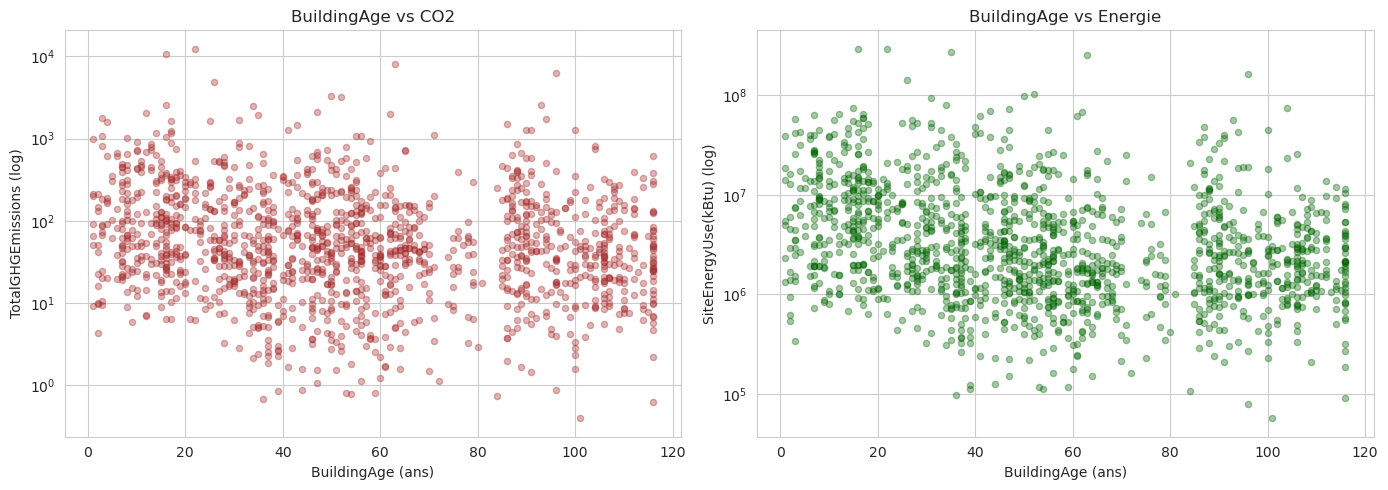

In [8]:
# Graphique explicatif: age du batiment vs cibles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['BuildingAge'], df['TotalGHGEmissions'], alpha=0.35, s=20, color='brown')
axes[0].set_yscale('log')
axes[0].set_title('BuildingAge vs CO2')
axes[0].set_xlabel('BuildingAge (ans)')
axes[0].set_ylabel('TotalGHGEmissions (log)')

axes[1].scatter(df['BuildingAge'], df['SiteEnergyUse(kBtu)'], alpha=0.35, s=20, color='darkgreen')
axes[1].set_yscale('log')
axes[1].set_title('BuildingAge vs Energie')
axes[1].set_xlabel('BuildingAge (ans)')
axes[1].set_ylabel('SiteEnergyUse(kBtu) (log)')

plt.tight_layout()
plt.show()

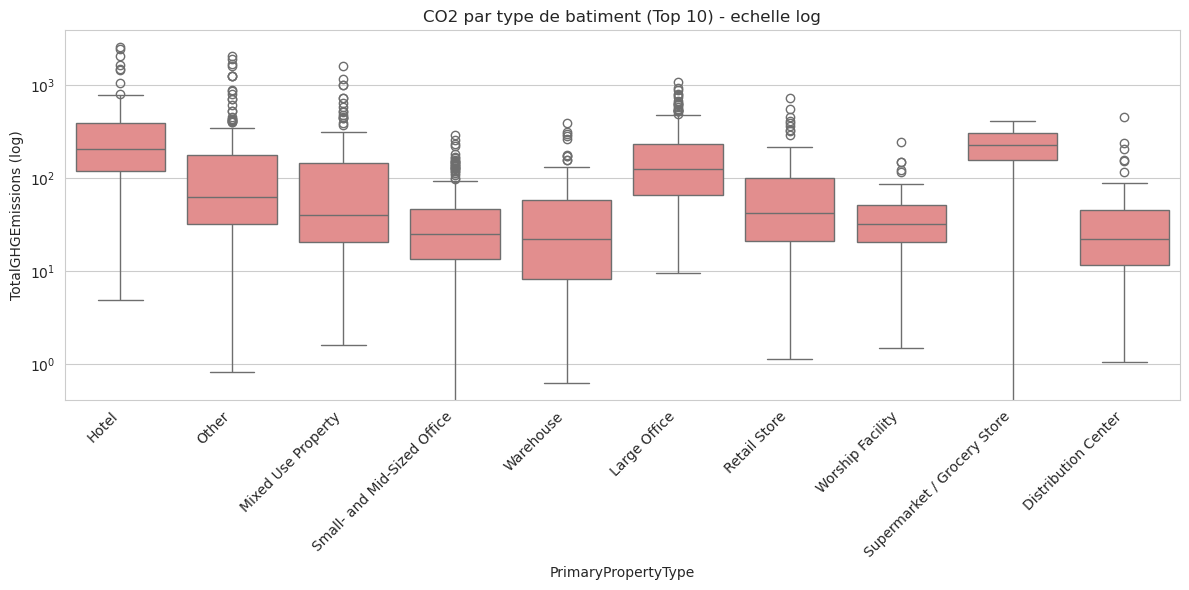

In [9]:
# CO2 par type de batiment (Top 10)
top_types = df['PrimaryPropertyType'].value_counts().head(10).index
plot_df = df[df['PrimaryPropertyType'].isin(top_types)].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='PrimaryPropertyType', y='TotalGHGEmissions', color='lightcoral')
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.title('CO2 par type de batiment (Top 10) - echelle log')
plt.xlabel('PrimaryPropertyType')
plt.ylabel('TotalGHGEmissions (log)')
plt.tight_layout()
plt.show()

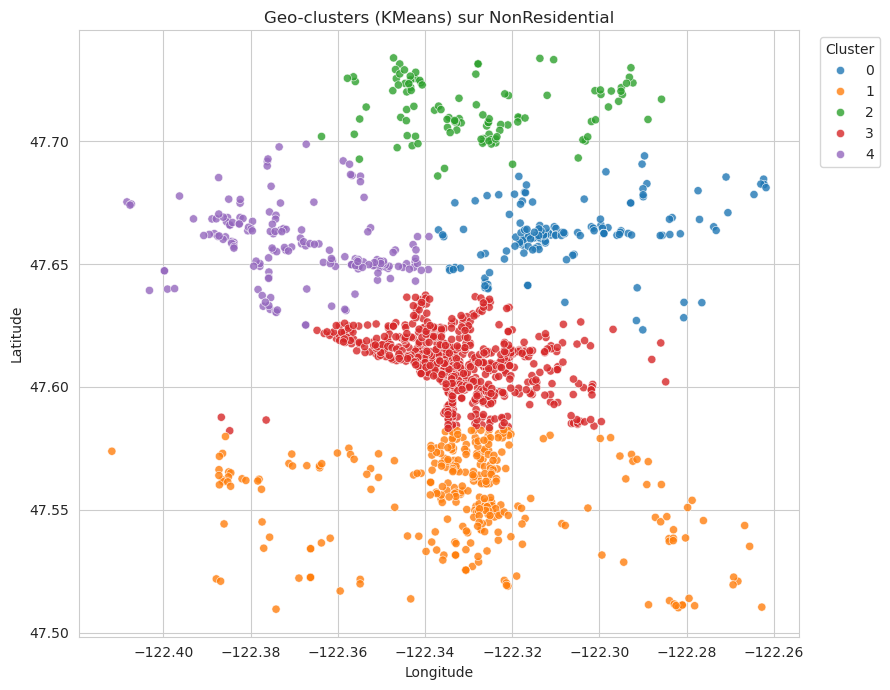

GeoCluster
0    144
1    322
2    108
3    690
4    168
Name: count, dtype: int64


In [10]:
# Geo-cluster simple avec latitude/longitude
geo_df = df.dropna(subset=['Latitude', 'Longitude']).copy()

k_geo = 5
geo_model = KMeans(n_clusters=k_geo, random_state=42, n_init=10)
geo_df['GeoCluster'] = geo_model.fit_predict(geo_df[['Latitude', 'Longitude']])

# Ajout du cluster au dataset principal
df = df.merge(
    geo_df[['OSEBuildingID', 'GeoCluster']],
    on='OSEBuildingID',
    how='left'
)
df['GeoCluster'] = df['GeoCluster'].astype('Int64').astype(str)

plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=geo_df,
    x='Longitude', y='Latitude',
    hue='GeoCluster',
    palette='tab10',
    s=35, alpha=0.8
)
plt.title('Geo-clusters (KMeans) sur NonResidential')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(df['GeoCluster'].value_counts(dropna=False).sort_index())

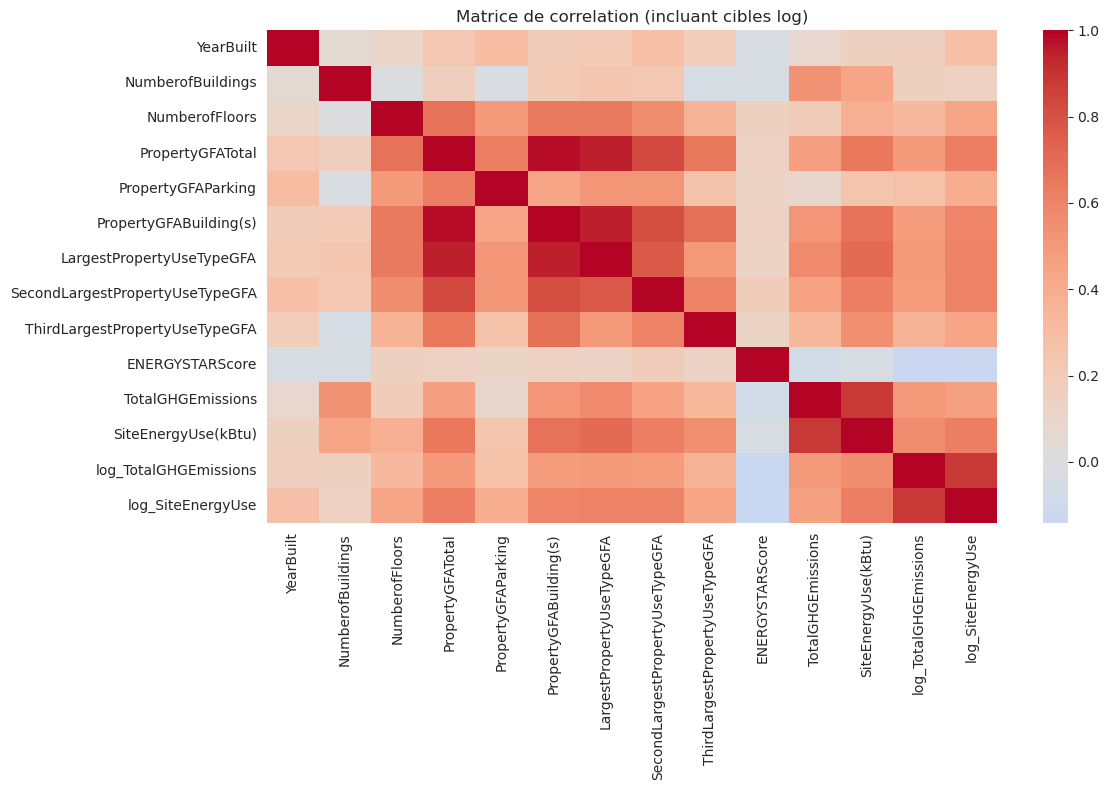

In [11]:
# Correlation explicative sur variables utiles
model_num = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
    'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
    'ENERGYSTARScore', 'TotalGHGEmissions', 'SiteEnergyUse(kBtu)'
]
model_num = [c for c in model_num if c in df.columns]

corr_df = df[model_num].copy()
corr_df['log_TotalGHGEmissions'] = np.log1p(corr_df['TotalGHGEmissions'])
corr_df['log_SiteEnergyUse'] = np.log1p(corr_df['SiteEnergyUse(kBtu)'])

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title('Matrice de correlation (incluant cibles log)')
plt.tight_layout()
plt.show()

# Variables importantes identifiées

In [ ]:
num_features = [
    'YearBuilt', 'BuildingAge', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA', 'ParkingRatio', 'MainUseRatio',
    'ENERGYSTARScore'
]
cat_features = ['PrimaryPropertyType', 'Neighborhood', 'GeoCluster']

## Conclusions EDA
- Le perimetre est strictement `NonResidential`.
- Les cibles CO2 et Energie sont fortement asymetriques: `log1p` est pertinent.
- Les surfaces (GFA) sont les variables les plus explicatives visuellement et statistiquement.
- Les distributions par type de batiment sont heterogenes, donc les variables categoriques doivent etre conservees.
- Un geo-clustering KMeans sur (Latitude, Longitude) cree une variable spatiale exploitable (`GeoCluster`).
- `BuildingAge` apporte un signal utile, complete par des variables derivees simples (ex: `AvgFloorArea`, `GFAperBuilding`).
